<a href="https://colab.research.google.com/github/Rodisolomon/Rodisolomon/blob/main/ml_large_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pylab as py
import torch
import numpy as np

# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm
from google.colab import drive
import matplotlib.pyplot as plt

# Data + Network + Preprocess

In [ ]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir = os.path.join('Users','amit','Google Drive')
    if os.path.isdir(os.path.join(predir,'My Drive')):
            predir=os.path.join(predir,'My Drive')
   
import torch
import numpy as np

# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir+'ml_large/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at ME


### Get Mnist data and split into train validation and test

In [ ]:
def get_mnist():
    data=np.float64(np.load(datadir+'MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

## Get cifar10 data and split into training, validation and testing.

In [ ]:
import h5py

def get_cifar():
    with h5py.File(datadir+'cifar10_train.hdf5', "r") as f:
        tr=f[('data')][:].transpose(0,3,1,2)
        tr_lb=f[('labels')][:]
    train_data=np.float32(tr[0:45000])/255.
    train_labels=tr_lb[0:45000]
    val_data=np.float32(tr[45000:])/255.
    val_labels=tr_lb[45000:]
    
    with h5py.File(datadir+'cifar10_test.hdf5', "r") as f:
        test_data=f[('data')][:].transpose(0,3,1,2)
        test_data=np.float32(test_data)/255.
        test_labels=f[('labels')][:]
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

### Get the data 

In [ ]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

### The network

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()
        
        ks=pars.kernel_size
        output_channel = pars.channel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, output_channel, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(output_channel, output_channel*2, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        

# RUN

## Run one epoch + test functions

In [ ]:
def run_epoch(net,epoch,train,pars,printing,num=None,ttype="train"):
    
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):
                
                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                
                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                

        train_loss /= len(y)
        if printing:
          print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
              train_loss, train_correct, len(y),
              100. * train_correct / len(y)))
        return train_loss


def net_test(net,val,pars,printing,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                if printing:
                  print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                      test_loss, test_correct, len(yval),
                      100. * test_correct / len(yval)))
                return test_loss
 
    


## Par, Run the training. Save the model and test at the end

In [ ]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=2000
        self.step_size=.001
        self.channel_size = 32
        self.num_epochs=5
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=[5,5]
        self.mid_layer=256
        self.use_gpu=False

pars=par()

In [ ]:
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'channel_size': 32,
 'num_epochs': 5,
 'numtrain': 55000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False}

In [ ]:
# Sample code for running a network
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, True, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars,True)


net_test(net,test,pars,True,ttype="test")

# Save the model to a file
if not os.path.isdir(os.path.join(predir,'tmp')):
    os.mkdir(os.path.join(predir,'tmp'))
torch.save(net.state_dict(), os.path.join(predir,'tmp',pars.model_name))

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 45329/55000 (82.42%)


Validation set: Avg. loss: 0.0001, Accuracy: 4823/5000 (96.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52945/55000 (96.26%)


Validation set: Avg. loss: 0.0000, Accuracy: 4925/5000 (98.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53761/55000 (97.75%)


Validation set: Avg. loss: 0.0000, Accuracy: 4952/5000 (99.04%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 54063/55000 (98.30%)


Validation set: Avg. loss: 0.0000, Accuracy: 4965/5000 (99.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54240/55000 (98.62%)


Validation set: Avg. loss: 0.0000, Accuracy: 4968/5000 (99.36%)


Test set: Avg. loss: 0.0000, Accuracy: 9855/10000 (98.55%)



### Regular Run Function

In [ ]:
def regular_run(new_net, cifar): ##all regular setting, take a network as an input
  pars=par()
  pars.device = device
  pars.num_epochs = 15
  if cifar == "cifar":
    pars.data_set = "cifar"

  train,val,test=get_data(data_set=pars.data_set)
  pars.inp_dim=train[0][0].shape
  # Initialize the network
  net = new_net(pars).to(pars.device)
  # Post it to the gpu if its there.
  net.to(pars.device)
  tr_loss, t_loss = [], []

  train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

  for i in range(pars.num_epochs):
      # Run one epoch of training
      tr_loss.append(run_epoch(net,i,train, pars, False, num=pars.numtrain, ttype="train"))
      # Test on validation set.
      t_loss.append(net_test(net,val,pars,False))
  print(f"final loss is {net_test(net,test,pars,False)}")
  return net, tr_loss, t_loss

In [ ]:
def plot_loss(tr_loss, t_loss):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  axs[0].plot([_ for _ in range(len(tr_loss))], tr_loss)
  axs[1].plot([_ for _ in range(len(t_loss))], t_loss)
  axs[0].set_title('Train Loss')
  axs[1].set_title('Validation Loss')

## Reload the model that was saved and continue training

In [ ]:
# train,val,test=get_data(data_set=pars.data_set)
# pars.new_model_name = 'model_continue'
# pars.inp_dim=train[0][0].shape
# net = MNIST_Net(pars).to(pars.device)

# print(pars.__dict__)
# state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
# net.load_state_dict(state_dict)
# net.eval()
# for i in range(pars.num_epochs):
#     run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
#     net_test(net,val,pars)

# net_test(net,test,pars, ttype="test")
# #save model
# torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)

# MNIST

## Q(a)

In [ ]:
# Parameter
# use GPU when possible
pars=par()
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of trainable parameters: **{total_params}**")

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738
Number of trainable parameters: **857738**


In [ ]:
# Run for 10 epoch
t_loss, tr_loss = [], []
for i in range(10):
    # Run one epoch of training
    tr_loss.append(run_epoch(net,i,train, pars,True, num=pars.numtrain, ttype="train"))
    # Test on validation set.
    t_loss.append(net_test(net,val,pars,True))

  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0005, Accuracy: 40740/55000 (74.07%)


Validation set: Avg. loss: 0.0001, Accuracy: 4676/5000 (93.52%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 50941/55000 (92.62%)


Validation set: Avg. loss: 0.0001, Accuracy: 4856/5000 (97.12%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 52819/55000 (96.03%)


Validation set: Avg. loss: 0.0000, Accuracy: 4903/5000 (98.06%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 53518/55000 (97.31%)


Validation set: Avg. loss: 0.0000, Accuracy: 4924/5000 (98.48%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 53841/55000 (97.89%)


Validation set: Avg. loss: 0.0000, Accuracy: 4954/5000 (99.08%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54005/55000 (98.19%)


Validation set: Avg. loss: 0.0000, Accuracy: 4951/5000 (99.02%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54154/55000 (98.46%)


Validation set: Avg. loss: 0.0000, Accuracy: 4958/5000 (99.16%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54257/55000 (98.65%)


Validation set: Avg. loss: 0.0000, Accuracy: 4961/5000 (99.22%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54410/55000 (98.93%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)



  0%|          | 0/28 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54471/55000 (99.04%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)



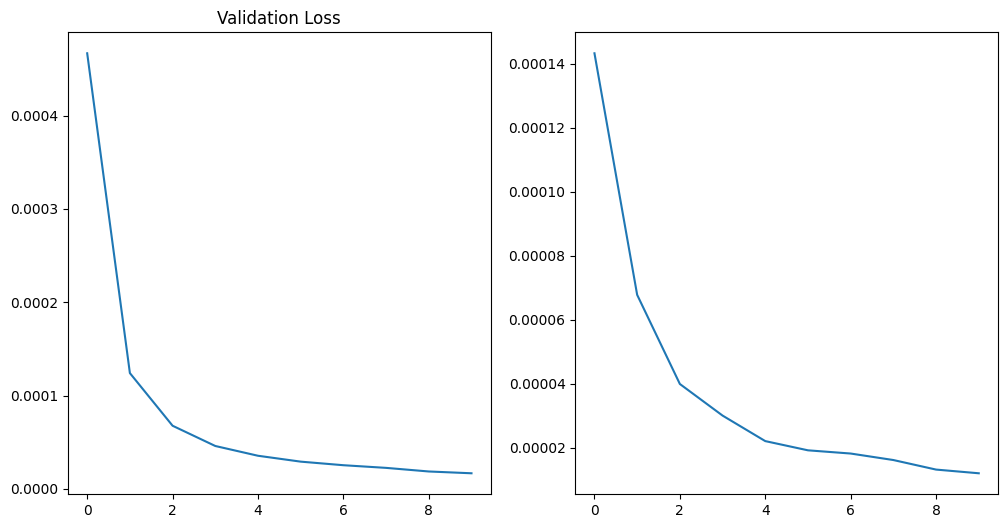

In [ ]:
#plot loss
def plot_loss(tr_loss, t_loss):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  axs[0].plot([_ for _ in range(len(tr_loss))], tr_loss)
  axs[1].plot([_ for _ in range(len(t_loss))], t_loss)
  axs[0].set_title('Train Loss')
  axs[1].set_title('Validation Loss')
  
plot_loss(tr_loss, t_loss)

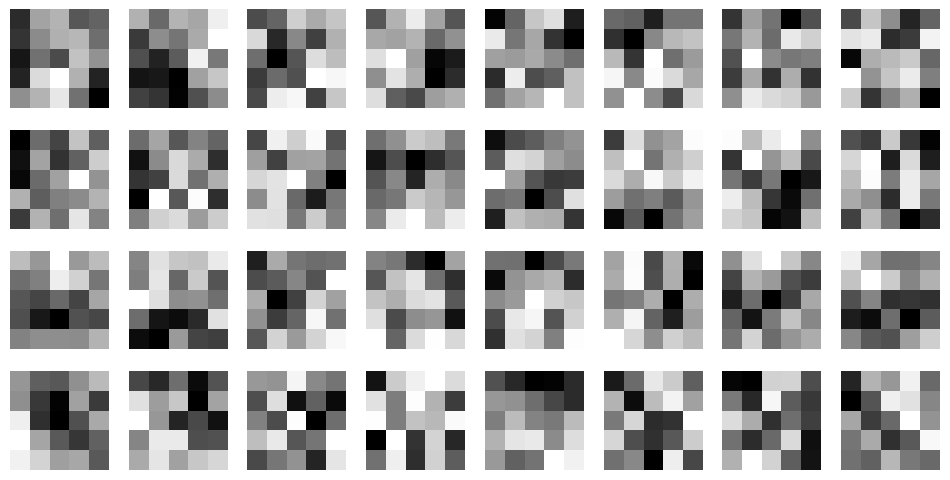

In [ ]:
# Graph
# extract the weights of the first convolutional layer
weights = net.conv1.weight.detach().cpu().numpy()

# plot the filters as images
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(12,6))
for i, ax in enumerate(axs.flat):
    if i < 32:
        filter = np.squeeze(weights[i, :, :, :])
        ax.imshow(filter, cmap='gray')
        ax.axis('off')
plt.show()

## Q(b)

In [ ]:
""" 
i. Keep the same number of layers and change layer parameters reducing number
of parameters by half in one experiment and doubling the number parameters in
another. Try a few different options. Report the results. 
"""
# default values:
# self.batch_size=1000
# self.step_size=.001
# self.channel_size = 32 
# self.num_epochs=5
# self.numtrain=55000
def modify_parameter(double, i):
  #i = change output channel, reverse kernel size
  
  p=par()
  if double:
    if i == "channel size":
      p.channel_size = 64
    elif i == "kernel size":
      p.kernel_size = [10, 10]
  else:
    if i == "channel size":
      p.channel_size = 16
    elif i == "kernel size":
      p.kernel_size = [2,2]
  p.device = device
  train,val,test=get_data(data_set=p.data_set)
  p.inp_dim=train[0][0].shape
  # Initialize the network
  net_small = MNIST_Net(p).to(p.device)
  # Post it to the gpu if its there.
  net_small.to(p.device)

  for i in range(p.num_epochs):
      # Run one epoch of training
      tr_loss.append(run_epoch(net_small,i,train, p, False, num=p.numtrain, ttype="train"))
      # Test on validation set.
      t_loss.append(net_test(net_small,val,p, False))
  print(f"the final training loss after {p.num_epochs} epoch is {tr_loss[-1]}, test loss is {t_loss[-1]}")

In [ ]:
for _ in [True, False]:
  for pattern in ["channel size", "kernel size"]:
    Str = "double" if _ else "half"
    print(f"====================when we {Str} the original network by operating {pattern}====================")
    modify_parameter(_, pattern)

====================when we double the original network by operating channel size====================
(70000, 784)
conv1 torch.Size([1, 64, 14, 14])
conv2 torch.Size([1, 128, 7, 7])
input dimension to fc1 6272
conv1.weight torch.Size([64, 1, 5, 5])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 5, 5])
conv2.bias torch.Size([128])
fc1.weight torch.Size([256, 6272])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1815050


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

the final training loss after 5 epoch is 3.0779084529389034e-05, test loss is 1.8320433981716633e-05
====================when we double the original network by operating kernel size====================
(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 10, 10])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 10, 10])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1013738


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

the final training loss after 5 epoch is 4.0934571556069635e-05, test loss is 2.751029971987009e-05
====================when we half the original network by operating channel size====================
(70000, 784)
conv1 torch.Size([1, 16, 14, 14])
conv2 torch.Size([1, 32, 7, 7])
input dimension to fc1 1568
conv1.weight torch.Size([16, 1, 5, 5])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 5, 5])
conv2.bias torch.Size([32])
fc1.weight torch.Size([256, 1568])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 417482


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

the final training loss after 5 epoch is 6.239911344918338e-05, test loss is 3.1643505580723285e-05
====================when we half the original network by operating kernel size====================
(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 2, 2])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 2, 2])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 814058


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

the final training loss after 5 epoch is 8.487671539187431e-05, test loss is 4.8145855590701105e-05


Observation: I got the smallest test loss after doubling the channel size. Double the kernel size has slightly smaller positive effect. The difference of test loss betweeen doubling and halfing is at the magnitude of 1e-5 

In [ ]:
""" 
ii. Design a deeper network with approximately the same number of parameters as
the original network. Report the results.
"""
def design_net(deeper, ds):
  class The_Net(nn.Module):
    def __init__(self,pars):
        super(The_Net, self).__init__()
        
        ks=pars.kernel_size
        output_channel = pars.channel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        if ds == "mnist":
          dim = 1
        else:
          dim = 3
          pars.data_set = "cifar"
        if deeper == None: #None means vanilla, deeper means slightly deeper, shift means ahifted image treatment, other means the deepest network
          print("None")
          self.conv1 = nn.Conv2d(dim, output_channel, kernel_size=ks[0],padding=ks[0]//2)
          self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
          self.conv2 = nn.Conv2d(output_channel, output_channel*2, kernel_size=ks[1],padding=ks[1]//2)
          self.drop2 = nn.Dropout2d(pars.dropout)
          self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
          self.drop_final=nn.Dropout(pars.dropout)
        elif deeper == "deeper":
          print("shallow deep network") 
          self.conv1 = nn.Conv2d(dim, output_channel, kernel_size=ks[0], padding=ks[0]//2)
          self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
          self.conv2 = nn.Conv2d(output_channel, output_channel*2, kernel_size=ks[1], padding=ks[1]//2)
          self.drop2 = nn.Dropout2d(pars.dropout)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv3 = nn.Conv2d(output_channel*2, output_channel*2, kernel_size=1, padding=0)
          self.conv4 = nn.Conv2d(output_channel*2, output_channel*2, kernel_size=3, padding=1)
          self.drop_final = nn.Dropout(pars.dropout)
        elif deeper == "shift":
          self.conv1 = nn.Conv2d(dim, output_channel, kernel_size=ks[0], padding=ks[0]//2)
          self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
          self.conv2 = nn.Conv2d(output_channel, output_channel*2, kernel_size=ks[1], padding=ks[1]//2)
          self.drop2 = nn.Dropout2d(pars.dropout)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv3 = nn.Conv2d(output_channel*2, output_channel*4, kernel_size=1, padding=0)
          self.conv4 = nn.Conv2d(output_channel*4, output_channel*8, kernel_size=3, padding=1)
          self.conv5 = nn.Conv2d(output_channel*8, output_channel*16, kernel_size=5, padding=1)
          self.conv6 = nn.Conv2d(output_channel*16, output_channel*16, kernel_size=5, padding=2)
          self.conv7 = nn.Conv2d(output_channel*16, output_channel*32, kernel_size=5, padding=2)  
          self.conv8 = nn.Conv2d(output_channel*32, output_channel*64, kernel_size=5, padding=2)  
          self.drop_final = nn.Dropout(pars.dropout)     
        elif deeper == "deepest":
          print("deep deep network") 
          self.conv1 = nn.Conv2d(dim, output_channel, kernel_size=ks[0], padding=ks[0]//2)
          self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
          self.conv2 = nn.Conv2d(output_channel, output_channel*2, kernel_size=ks[1], padding=ks[1]//2) #one layer deeper
          self.drop2 = nn.Dropout2d(pars.dropout)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv3 = nn.Conv2d(output_channel*2, output_channel*2, kernel_size=3, padding=1)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv4 = nn.Conv2d(output_channel*2, output_channel*2, kernel_size=5, padding=1)
          self.conv5 = nn.Conv2d(output_channel*2, output_channel*2, kernel_size=5, padding=1)
          self.drop_final = nn.Dropout(pars.dropout)         
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
  return The_Net
    
        

In [ ]:
#original network
regular_run(design_net(None, "mnist"), "mnist")

(70000, 784)
None
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 1.9967073015868664e-05


MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=[2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop2): Dropout2d(p=0.0, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_final): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc_final): Linear(in_features=256, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [ ]:
#shallower deeper network
regular_run(design_net(False, "mnist"), "mnist")

(70000, 784)
deep deep network
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 5, 5])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 997130


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 1.1477180663496255e-05


In [ ]:
#deeper
regular_run(design_net(True, "mnist"), "mnist")

(70000, 784)
shallow deep network
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 1, 1])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 3, 3])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 898826


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 1.1988020967692137e-05


deeper CNN1: one more Conv layer of output channel = pars.channel_size*2 and kernel_size = 3

deeper CNN2: two more Conv layer of output channel = pars.channel_size*2 and kernel_size = 5

Based on the final result, I pick network 2 (the second deep one). The final loss is slightly higher than the previous section by applying test data instead of validation data to it.

In [ ]:
"""
iii. Once you pick the best configuration try it on the full training set and report the
result
"""
regular_run(design_net(False, "mnist"), "mnist")

(70000, 784)
deep deep network
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 5, 5])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 997130


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 1.8078917637467384e-05


## Q(C)

(c) Handling variability. A randomly shifted test set is been created in the function `get_mnist_trans`
by taking each digit and applying random shift sampled uniformly between `+/− shift/2` pixels in each direction. For different sizes of shift Display a few of these examples
alongside the original digits.

Using the original trained network to test on this data set. Show the classification rate as a function of `shift`.


Try to propose changes to the network architecture so that still training on the original training set you would perform better on the transformed test set. Perform some experiments using a transformed validation set and show the final results on the transformed test set.

In [ ]:
import pylab as py
def get_mnist_trans(test,shift):
    ll=test.shape[0]
    shift2=shift//2
    uu=np.int32((np.random.rand(ll,2)-.5)*shift)
    test_t=[]
    fig = py.figure(figsize=(8, 6))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test[j,0])
      py.axis('off')
    py.show()
    for i,t in enumerate(test):
        tt=np.zeros((28+shift+1,28+shift+1))
        tt[shift2:shift2+28,shift2:shift2+28]=t
        ttt=tt[shift2+uu[i,0]:shift2+uu[i,0]+28,shift2+uu[i,1]:shift2+uu[i,1]+28]
        test_t.append(ttt.reshape(1,28,28))
    test_labels=np.int32(np.load(datadir+'MNIST_labels.npy'))
    test_trans_dat=np.float32(np.concatenate(test_t,axis=0).reshape((-1,1,28,28)))
    fig = py.figure(figsize=(8, 6))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test_trans_dat[j,0])
      py.axis('off')
    py.show()
    print(test_trans_dat.shape)
    return (test_trans_dat, test_labels[60000:])

(70000, 784)


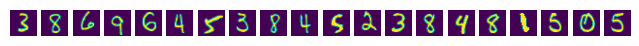

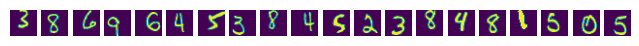

(10000, 1, 28, 28)


In [ ]:
pars=par()
pars.device = device
train,val,test=get_data(data_set=pars.data_set)

ret = get_mnist_trans(test[0],10)


In [ ]:
my_net = regular_run(design_net(False, "mnist"), "mnist")

(70000, 784)
deep deep network
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 5, 5])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 997130


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 2.096734307706356e-05


In [ ]:
pars = par()
pars.device = device
pars.num_epochs = 30
fin = net_test(my_net,ret,pars,True)



Validation set: Avg. loss: 0.0008, Accuracy: 7501/10000 (75.01%)



In [ ]:
shift_net = regular_run(design_net("shift", "mnist"), "mnist")
pars = par()
pars.device = device
pars.num_epochs = 30
fin = net_test(shift_net,ret,pars,True)

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 1, 1])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size([512, 256, 5, 5])
conv5.bias torch.Size([512])
conv6.weight torch.Size([512, 512, 5, 5])
conv6.bias torch.Size([512])
conv7.weight torch.Size([1024, 512, 5, 5])
conv7.bias torch.Size([1024])
conv8.weight torch.Size([2048, 1024, 5, 5])
conv8.bias torch.Size([2048])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 76531722


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

final loss is 1.8132597766816615e-05

Validation set: Avg. loss: 0.0007, Accuracy: 7702/10000 (77.02%)



In order to improve performance of CNN on shifted images, I applied some modification on the architecture. I decide to increase the parameter of the CNN. I was thinking of data augmentation method but that seees to change the trainign dataset. there's improvement of 2% in the end. It's really hard to reduce the error rate without using augmentation method

CNN to treat shift/change of contrast: Conv layer 2 to 8 with increasing output channel size (pars.channel_size*2 -> 64) and kernel size (1->5)

# CIFAR10

## Q(a)

In [ ]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = get_cifar()

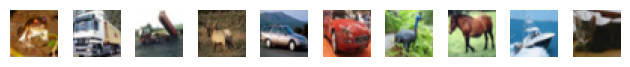

In [ ]:
fig, axes = plt.subplots(1, 10)
for i, ax in enumerate(axes):
    image, label = train_data[i], train_labels[i]
    image = np.transpose(image, (1, 2, 0)) 
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Q(b)

None
conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1105098


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

final loss is 0.0005360174298286438


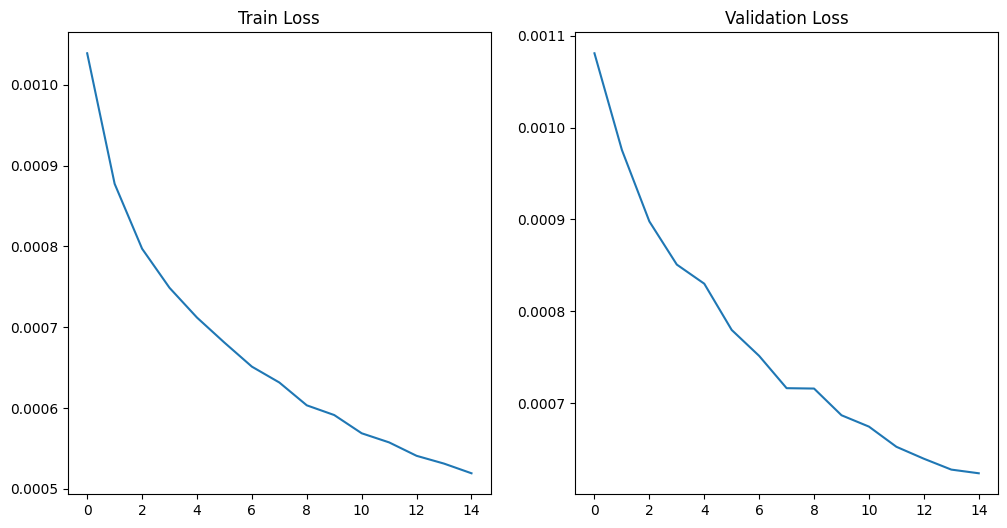

In [ ]:
"""
(b) Modify the code to apply the original network to the cifar data. Remember that the
images now have 3 color channels. Again plot training and validation error against
epoch number. Plot the first layer filters.
"""
## I use the design_net and run_regular function in MNIST Q(b) section
net, tr_loss, t_loss = regular_run(design_net(None, "cifar"), "cifar")
plot_loss(tr_loss, t_loss)

## Q(c)

I use the same setting of deeper CNN as in MNIST part b

shallow deep network
conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 1, 1])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 3, 3])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1146186


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

final loss is 0.0005324241638183594


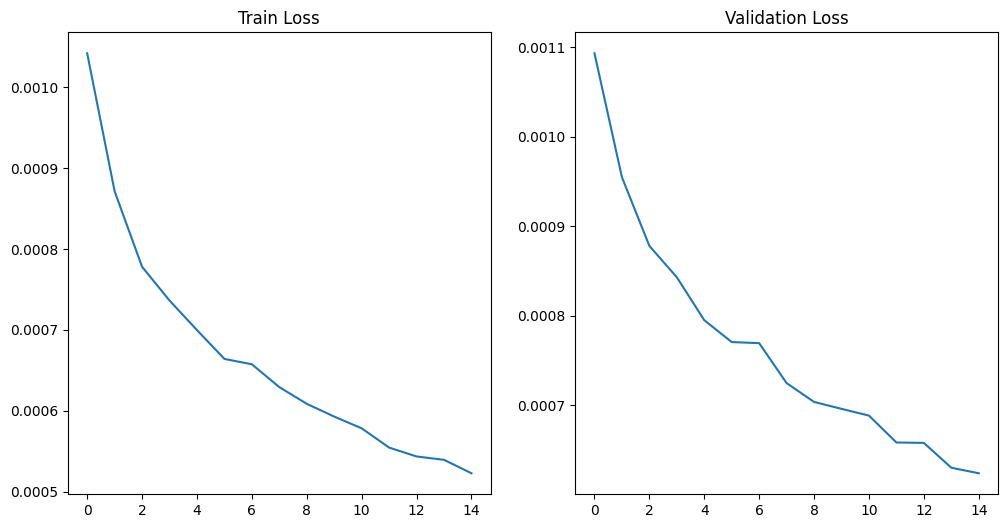

In [ ]:
"""
(c) Try to define a deeper network and see if you get an improvement.
"""
net, tr_loss, t_loss = regular_run(design_net("deeper", "cifar"), "cifar")
plot_loss(tr_loss, t_loss)

deep deep network
conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
conv4.weight torch.Size([64, 64, 5, 5])
conv4.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1244490


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

final loss is 0.0005184409856796265


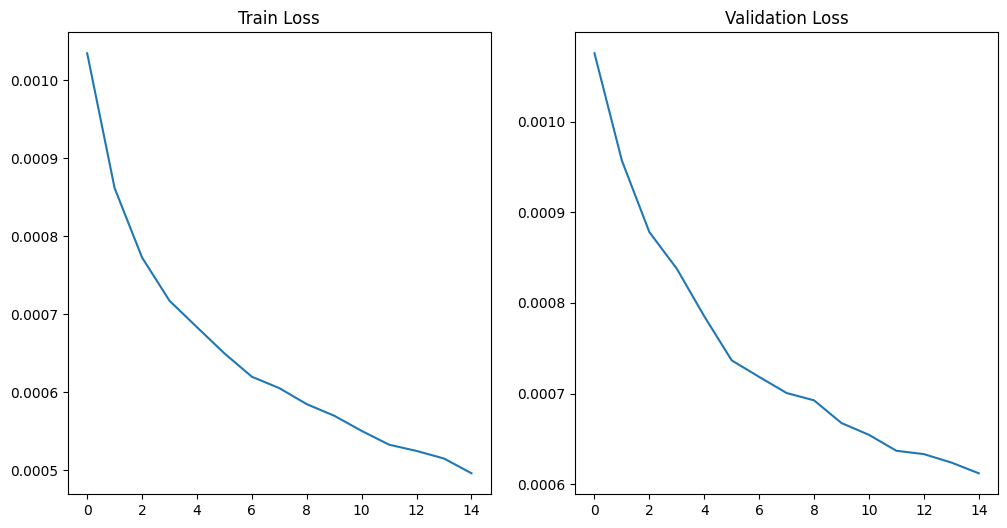

In [ ]:
net, tr_loss, t_loss = regular_run(design_net("deepest", "cifar"), "cifar")
plot_loss(tr_loss, t_loss)

Observation: There is an improving error rate by using a deeper and deeper network (0.0005543 to 0.000532 to 0.000531)

## Q(d)


Handling variability. Use `skimage.color.rgb2hsv` to transform the rgb color map of the input images to and hsv - hue, saturation, value. You can use hsv2rgb to transform back. (To read more about different color coding methods see: https://en.wikipedia.org/wiki/HSL_and_HSV. Saturation is a value between 0 and 1 providing a sense of how ‘colorful’ the pixel is.) For each image in the test set multiply the saturation of all pixels values by a fixed value drawn randomly between .75 and 1.25. Then convert back to RGB. Show some of the resulting images. Run the model on the modified data and report the result.

In [ ]:
from skimage.color import rgb2hsv, hsv2rgb
import random

def single_image_modification(image, factor): ##function used to mo
  hsv_img = rgb2hsv(image)
  hsv_img[..., 1] *= factor
  hsv_img = np.clip(hsv_img, 0, 1)
  return hsv2rgb(hsv_img)

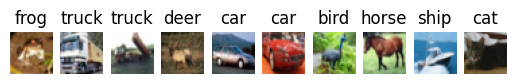

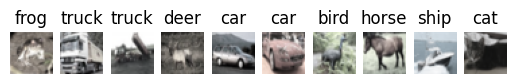

In [ ]:
fig, axes = plt.subplots(1, 10)
for i, ax in enumerate(axes):
    image, label = train_data[i], train_labels[i]
    image = np.transpose(image, (1, 2, 0)) 
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')
plt.show()
fig, axes = plt.subplots(1, 10)
for i, ax in enumerate(axes):
    image, label = train_data[i], train_labels[i]
    image = np.transpose(image, (1, 2, 0))
    factor = 0.2 # the correct one is factor = random.uniform(0.75, 1.25), just want to show that this function is working
    image = single_image_modification(image, factor)
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')
plt.show()

In [ ]:
print(train_data[0].shape)
new = np.transpose(image, (1, 2, 0))
new_new = np.transpose(image, (2, 0, 1))
print(new.shape, new_new.shape)

(3, 32, 32)
(32, 3, 32) (3, 32, 32)


In [ ]:
#(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = get_cifar()
def modify(data):
  for i in range(data.shape[0]):
    img = data[i]
    factor = random.uniform(0.75, 1.25)
    img = np.transpose(img, (1, 2, 0))
    new_img = single_image_modification(img, factor)
    data[i] = np.transpose(new_img, (2, 0, 1))
  return data

train_data, val_data, test_data = modify(train_data), modify(val_data), modify(test_data)

used the original model for test: the accuracy drop to about 63.67%. Similar to the image shift, this will be improved by using data augmentation. 

In [ ]:
test = (test_data, test_labels)
net_test(net,test,pars,True,ttype="test")


Test set: Avg. loss: 0.0005, Accuracy: 6367/10000 (63.67%)



0.0005201770067214965

train a model based on modified data, the result is not that different from the original dataset

In [ ]:
print(train_data.shape)

(45000, 3, 32, 32)


In [ ]:
m_train, m_vali, m_test = (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [ ]:

def irregular_run(new_net, cifar): ##all regular setting, take a network as an input
  pars=par()
  pars.device = device
  pars.num_epochs = 15
  if cifar == "cifar":
    pars.data_set = "cifar"

  train,val,test=get_data(data_set=pars.data_set)
  train_x = modify(train[0])
  val_x = modify(val[0])
  test_x = modify(test[0])
  train,val,test = (train_x, train[1]),(val_x, val[1]), (test_x,test[1])
  pars.inp_dim=train[0][0].shape
  # Initialize the network
  net = new_net(pars).to(pars.device)
  # Post it to the gpu if its there.
  net.to(pars.device)
  tr_loss, t_loss = [], []

  train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

  for i in range(pars.num_epochs):
      # Run one epoch of training
      tr_loss.append(run_epoch(net,i,train, pars, False, num=pars.numtrain, ttype="train"))
      # Test on validation set.
      t_loss.append(net_test(net,val,pars,False))
  print(f"final loss is {net_test(net,test,pars,False)}")
  return net, tr_loss, t_loss

In [ ]:
net, tr_loss, t_loss = irregular_run(design_net(None, "cifar"), "cifar")

None
conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1105098


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

final loss is 0.0005335313200950623


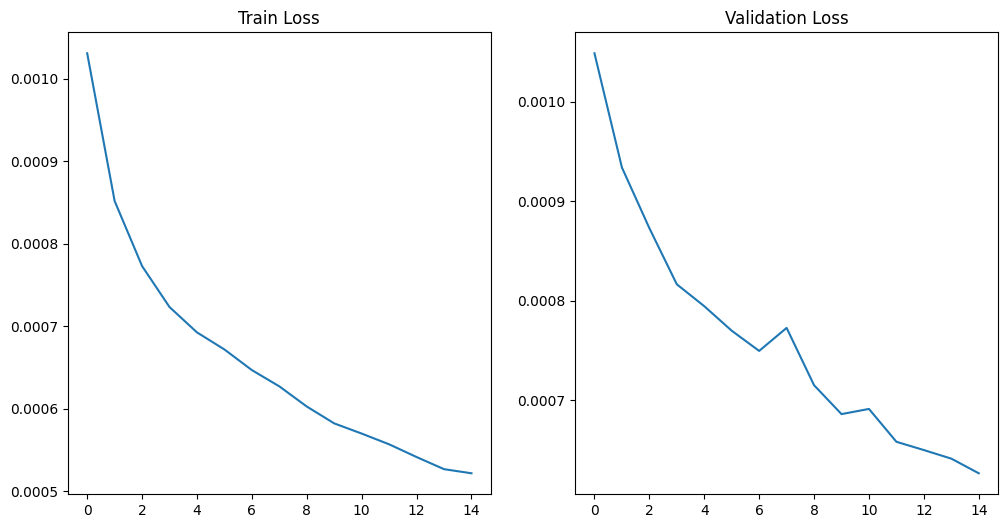

In [ ]:
plot_loss(tr_loss, t_loss)